In [6]:
import cxgnncomp as cxgc
import numpy as np
import torch
from os import path

dset = "papers100M"

# import argparse

# parser = argparse.ArgumentParser()
# parser.add_argument("--dataset", type=str, default="papers100M")
# args = parser.parse_args()

# dset = args.dataset
if dset == "friendster":
    infeat = 384
elif dset == "papers100M":
    infeat = 128
else:
    raise ValueError(f"Unknown dataset {dset}")
num_device = 4

total_num_node = int(
    open(path.join(f"/home/huangkz/data/dataset_diskgnn/{dset}/processed", "num_nodes.txt")).readline())
total_num_node = (total_num_node + num_device - 1) // num_device * num_device
assert total_num_node % 4 == 0

batches = []

for i in range(num_device):
    feat, ptr, idx, b = cxgc.prepare_graph(
        dset=dset,
        feat_len=infeat,
        num_head=1,
        num_seeds=1000,
        is_full_graph=0,
        need_edge_index=False,
        device=i)
    feat = None
    batches.append(cxgc.Batch(x=None, ptr=ptr, idx=idx, num_node_in_layer=b["num_node_in_layer"]))
    batches[-1].ptrs = [batches[-1].ptr.to(dev) for dev in range(num_device)]
    batches[-1].idxs = [batches[-1].idx.to(dev) for dev in range(num_device)]
    batches[-1].sub_to_fulls = [b["sub_to_full"].to(dev) for dev in range(num_device)]
local_feats = [torch.randn(total_num_node, infeat // num_device, device=i) for i in range(num_device)]


dataset prepared torch.Size([157167]) torch.Size([1570847]) torch.Size([1309707, 128]) tensor([   1000,   12629,  157166, 1309707])
dataset prepared torch.Size([149338]) torch.Size([1486775]) torch.Size([1239382, 128]) tensor([   1000,   12204,  149337, 1239382])
dataset prepared torch.Size([151000]) torch.Size([1505910]) torch.Size([1252536, 128]) tensor([   1000,   12283,  150999, 1252536])
dataset prepared torch.Size([154432]) torch.Size([1541734]) torch.Size([1280768, 128]) tensor([   1000,   12579,  154431, 1280768])


In [7]:
import cxgnncomp_backend

class Trainer():
    def __init__(self, num_device, total_num_node, infeat, local_feats, type="ddp"):
        self.num_device = num_device
        self.total_num_node = total_num_node
        self.infeat = infeat
        self.type = type
        if type == "ddp":
            self.local_starts = [i * total_num_node // num_device for i in range(num_device)]
            self.local_ends = [(i + 1) * total_num_node // num_device for i in range(num_device)]
            self.local_feats = [item.reshape(-1, infeat) for item in local_feats]
            # self.local_feats = [torch.randn(self.local_ends[i] - self.local_starts[i], infeat, device=i) for i in range(num_device)]
            self.convs = []
        elif type in ["tp", "opt"]:
            # self.local_feats = [torch.randn(total_num_node // num_device, infeat, device=i) for i in range(num_device)]
            self.local_starts = [i * infeat // num_device for i in range(num_device)]
            self.local_ends = [(i + 1) * infeat // num_device for i in range(num_device)]
            # self.local_feats = [torch.randn(self.total_num_node, self.local_ends[i] - self.local_starts[i], device=i) for i in range(num_device)]
            self.local_feats = [item.reshape(-1, infeat // num_device) for item in local_feats]
            # self.weights = [torch.randn(infeat, infeat, device=i) for i in range(num_device)]
    
    def set_hidden(self, hidden):
        self.hidden = hidden
        if self.type in ["ddp", "opt"]:
            self.weights = [torch.randn(self.infeat, hidden, device=i) for i in range(self.num_device)]
        elif self.type == "tp":
            self.weights = [torch.randn(self.infeat // self.num_device, hidden, device=i) for i in range(self.num_device)]

    def generate_x(self, batches):
        if self.type == "ddp":
            self.generate_x_ddp(batches)
        elif self.type == "tp":
            self.generate_x_tp(batches)
        elif self.type == "opt":
            self.generate_x_opt(batches)
        else:
            assert False

    def generate_x_ddp(self, batches):
        for i, batch in enumerate(batches):
            feats = []
            for j in range(self.num_device):
                # j -> i
                torch.cuda.set_device(j)
                sub_to_full = batch.sub_to_fulls[j]
                needed = sub_to_full[torch.logical_and(sub_to_full >= self.local_starts[j], sub_to_full < self.local_ends[j])]
                feats.append(self.local_feats[j][needed - self.local_starts[j]].to(i))
            torch.cuda.set_device(i)
            batch.x = torch.cat(feats, dim=0)

        for i, batch in enumerate(batches):
            torch.cuda.set_device(i)
            if self.infeat > self.hidden:
                x = torch.mm(batch.x, self.weights[i])
                batch.x = cxgnncomp_backend.sage_sum_forward(
                    x,
                    batch.ptrs[i],
                    batch.idxs[i],
                    batch.num_node_in_layer[-2]
                )
            else:
                x = cxgnncomp_backend.sage_sum_forward(
                    batch.x,
                    batch.ptrs[i],
                    batch.idxs[i],
                    batch.num_node_in_layer[-2]
                )
                batch.x = torch.mm(x, self.weights[i])

        

    def generate_x_tp(self, batches):
        outputs = []
        for tar_it in range(self.num_device):
            arr_node_feat = []
            for dev_it in range(self.num_device):
                torch.cuda.set_device(dev_it)
                out = torch.index_select(
                    self.local_feats[dev_it],
                    dim=0,
                    index=batches[tar_it].sub_to_fulls[dev_it]
                )
                out = cxgnncomp_backend.sage_sum_forward(
                    out,
                    batches[tar_it].ptrs[dev_it],
                    batches[tar_it].idxs[dev_it],
                    batches[tar_it].num_node_in_layer[-2]
                )
                out = torch.mm(out, self.weights[dev_it])
                # arr_node_feat[tar_it][dev_it] = out
                arr_node_feat.append(out)
            batches[tar_it].x = arr_node_feat[tar_it]
            for dev_it in range(self.num_device):
                if dev_it == tar_it:
                    continue
                batches[tar_it].x += arr_node_feat[dev_it].to(tar_it)

    def generate_x_opt(self, batches):
        for tar_it in range(self.num_device):
            arr_node_feat = []
            for dev_it in range(self.num_device):
                torch.cuda.set_device(dev_it)
                out = torch.index_select(
                    self.local_feats[dev_it],
                    dim=0,
                    index=batches[tar_it].sub_to_fulls[dev_it]
                )
                out = cxgnncomp_backend.sage_sum_forward(
                    out,
                    batches[tar_it].ptrs[dev_it],
                    batches[tar_it].idxs[dev_it],
                    batches[tar_it].num_node_in_layer[-2]
                )
                # out = torch.mm(out, self.weights[dev_it])
                arr_node_feat.append(out)
            # batches[tar_it].x = arr_node_feat[tar_it]
            collect_feat = [] 
            for dev_it in range(self.num_device):
                collect_feat.append(arr_node_feat[dev_it].to(tar_it))
                # batches[tar_it].x += arr_node_feat[dev_it].to(tar_it)
            batches[tar_it].x = torch.cat(collect_feat, dim=1)
            batches[tar_it].x = torch.mm(batches[tar_it].x, self.weights[tar_it])

In [8]:
ans = []
for type in ["opt", "ddp", "tp"]:
    hidden = 32
    print(type)
    trainer = Trainer(num_device, total_num_node, infeat, local_feats, type=type)
    # trainer.generate_x(batches)
    # print("dgl\tp3\tNollie")
    outputs = []
    while hidden <= 1024:
        trainer.set_hidden(hidden)
        t = cxgc.prof("dgl", "ddp", lambda: trainer.generate_x(batches), display=False)[
            0
        ]
        print(t)
        outputs.append(t)
        if hidden == 1024:
            print(batches[0].x)
        # P3:
        # dgl = num_src * infeat * (num_device - 1) / num_device
        # p3 = num_dst * hidden * (num_device - 1)
        # our = num_dst * min(hidden * (num_device - 1), infeat * (num_device - 1) / num_device)
        # print(f"{dgl}\t{p3}\t{our}\t{hidden}")
        hidden *= 2
    ans.append(outputs)

opt
12.147711753845215
12.270591735839844
12.514304161071777
13.309951782226562
14.924799919128418
18.819072723388672
tensor([[-30.7966,  -6.9260,  49.8330,  ...,  34.6754,  54.3585,  32.1230],
        [ 27.9922,  80.6672,  16.7926,  ..., -33.5524, -16.3463,  41.4517],
        [ -1.1880,  16.3319,   9.9136,  ...,  19.6074, -16.2996,  -5.0775],
        ...,
        [ 25.6360,   6.8436,  -3.3248,  ...,  24.9955, -14.6278, -67.2271],
        [-34.4493, -50.8766,  18.0307,  ...,  53.4627,   6.2706, -36.9139],
        [ 28.1951, -27.2477,  47.3612,  ..., -66.6699, -46.8796, -62.2885]],
       device='cuda:0')
ddp
79.55763244628906
80.34815979003906
79.78495788574219
79.99180603027344
80.58470153808594
81.75923156738281
tensor([[ 57.7467,  30.2829,  25.7198,  ..., -30.7881, -42.8543, -15.2956],
        [ 88.5854,  13.7262, -33.1186,  ..., -43.4898,  66.9673, -22.0199],
        [ -0.3406,   4.0421,   7.8622,  ...,   6.3294,  -2.6660,  10.5622],
        ...,
        [ 49.9884,  36.5109,   9.20

Text(0.5, 1.0, 'papers100M')

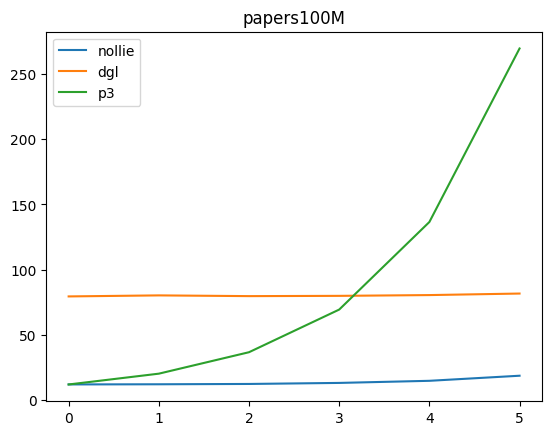

In [9]:
import matplotlib.pyplot as plt
plt.plot(ans[0], label="nollie")
plt.plot(ans[1], label="dgl")
plt.plot(ans[2], label="p3")
plt.legend()
plt.title(dset)